# CAB420 Metric Learning, Bonus Example: TFDS and Triplet Mining
Dr Simon Denman (s.denman@qut.edu.au)

### What is a "Bonus" Example?

These are extra examples that cover content outside the scope of CAB420. It exists becuase of one or more of the following reasons:
* It's closely related to other stuff we're looking at and I wanted to include it, but the course has too much content already, so I punted it here; 
* It's interesting;
* Someone (probably multiple someones if I wrote an example) has asked a question about it before.

You can freely ignore this example if you want. You really don't have to be reading this. You could go outside, go read a book, have a nap, take up a hobby, whatever you want really. The point I want to make here **this example really is optional**. Things here won't appear on an exam, or in an assignment (though you could use this in an assignment if you wanted). But if you're interested, this is here, and if you're reading this, so are you. 

Some things to note with bonus examples:
* These may gloss over details that elsewhere get more coverage. I may skip plots I'd normally include, or gloss over other details. The expecatation is that if you're reading this, you've looked at all the "core" examples and are comfortable with what they're doing. 
* Some bits of code might not be as well explained or explored as you're used to in the other examples. These examples are here for interested students looking to extend their knowledge, and I'm assuming if you're here, you're comfortable figuring code out, debugging stuff, and generally googling about to help work out what something is doing.
* There's no Tl;DR section at the top. If you're here, I'm assuming it's because you're interested and want all the gory details and don't just need the quick summary at the top.
* While my regular examples (the "core" ones) certainly contain their fare share of silly remarks and typos, expect the level of flippancy and the prevalence of typos increase in a bonus example. 

That said, as always, if you are stuggling to follow what I've got in here please shoot me a message. The aim is still for this to be clear enough to follow afterall.

## Overview

If you're here, I am expecting that you've gone through the metric learning content, and have a pretty good idea of what is hapenning when we implelement a triplet loss. Hopefully, you'll also have worked through the prac (if not, stop reading this and go and do that). Having gone through the triplet network faff a few times, you might be a bit over it, and be of the opinion that the whole process of setting up your generator, building triplets, passing them through multiple branches, etc, is too much bother.

However, in a dramatic plot twist, it turns out that there is an easier way. Before you get all upset that we went through the other way first, please put your pitchfork down and keep in mind that:
* The other way is not that bad. You should see what it looks like in MATLAB for example. Really, it's pretty easy to set up a triplet loss.
* It's really important to understand what's going on with these metric learning methods, and what's actually being minimised by the training process. The approach we're going to explore here really hides of all the important stuff where we get distances between triplets, and seek to minmise that. So having an understanding of what's actually going on is important, as the code we're going to use here doesn't capture the underlying mechanics at all.

With that out the way, there are a few limitations of our previous triplet approaches that are worth highlighting:
* We have to generate all of our triplets in advance.
* Not all triplets are good learning examples. By that, I mean a lot of them are possibly very easy. They contain a positive pair that is very similar, and a negative image that is clearly very different. Ideally, we'd like triplets where things are a bit less obvious (if you're not certain about what I mean here, have a look at the "semi-hard and hard triplets" section below.
* It's not super efficient. We have to pass three images through the network to generate a single training example. In a batch of 128 triplets, 384 images go through the backbone. There's simply a lot of underutilisation there.
* The prior approach doesn't scale cleanly to large (i.e. cannot fit in memory) datasets. How would you integrate it with tfds for each to stream data into the model?

The solution to the above woes is to not create triplets - or at least to not create triplets at the input to the network. To explain this, consider a typical network like we've done (over and over again) for classification. Think about what a batch of that data looks like. We have $N$ samples, each of those samples has it's data, and a class label. Within that one batch of data, there may exist dozens, or hundreds, of potential triplets. So rather than pass triplets into the network, why not pass a batch of data through, get the embeddings, and then create a huge set of triplets? What's more, having created these triplets we could just keep the ones that are interesting for learning. This process is referred to as online triplet mining, and if you'd like a really good breakdown of how this is achieved in code, [this blog post](https://omoindrot.github.io/triplet-loss) is well worth a read. Here, we'll just the loss function in the tensorflow addons package to achieve our aims.

### Semi-Hard and Hard Triplets

Recall the triplet loss:

$L = max(d(p,a) - d(n,a) + margin, 0)$

where $d$ is some distance function, $a$ is the embedding for the anchor sample, $p$ is the embedding for the positive sample (i.e. the same class as the anchor), and $n$ is the embedding for the negative sample (different class to the anchor). The aim of the triplet loss is to make $d(p,a)$ as close to 0 as possible, and ensure that $d(n,a)$ is equal to $d(p,a) + margin$, or more.

As we start to train a network, we can end up with three types of triplets:
* Easy Triplets. These are ones where the loss is 0, i.e. $d(p,a) + margin < d(n,a)$. As the loss for these is 0, there's nothing more than we can learn from these.
* Semi-Hard Triplets. These are ones where $d(p,a) < d(n,a) < d(p,a) + margin$, i.e. our positive and anchor pair are closer together than the negative and anchor, but the gap between them isn't quite as big as we'd like.
* Hard Triplets. These are the ones that are flat out wrong, $d(n,a) < d(p,a)$, i.e. the negative pair is closer together than the positive pair.

The first kind of triplets are not going to give us a useful signal for the learning, only the second and third types will.

### Where does this fit into all the other CAB420 content?

This example is a bit of theoretical/conceptual extension to the metric learning content, but has the added benefit of greatly simplifying the code you need to write. Like the other TFDS example from earlier, I expect this will be of most use for Assignment 2 (but you may also want to use this elsewhere).

### TensorFlow Addons, and Deprecation

This example originally used tensorflow addons for the losses. This has since been deprecated. As such, in the code below you'll see a rather large dump of code that looks quite a bit different from what surrounds it. This is the copy-paste dump from tensorflow addons.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import keras
from keras import layers
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np
import time

from sklearn.manifold import TSNE

tf.config.optimizer.set_jit(False)

### Data

I'm going to use tfds here, and I'll pull fashion MNIST down through that. I'll stick to fashion MNIST for consistency, despite the temptation to play with other random things.

We'll then use the tfds pipeline to set up our augmentation. This will make training with augmented data much easier than it otherwise may have been if we stuck to the offline triplet mining approach that used in the main examples.

The process here is very much like that that was used in the bonus tfds example. If this is unclear, go and have a look over there.

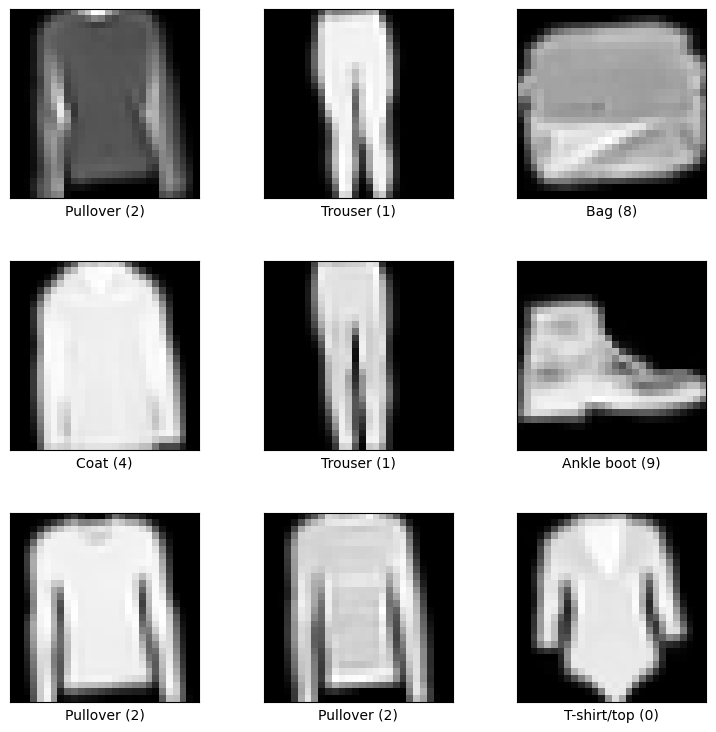

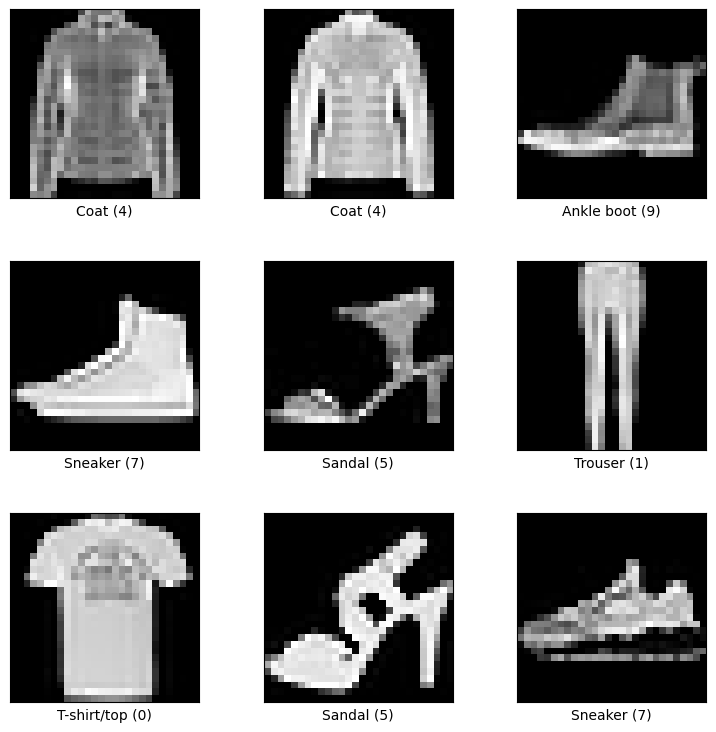

In [2]:
(ds_train, ds_val, ds_test), ds_info = tfds.load('fashionMNIST',
    split=['train[:90%]', 'train[90%:]', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

batch_size = 128
AUTOTUNE = tf.data.AUTOTUNE

# rescaling operation. No resizing here as we already have small images (32x32)
rescale = keras.Sequential([
  layers.Rescaling(1./255)
])

# augmentation operations
augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom((-0.1, 0.1)),
])

# function to apply rescaling and augmentation (if wanted)
def prepare_ds(ds, augment=False):

    # apply preprocessing (resizing and rescale)
    ds = ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)

    # Use data augmentation only if requested
    if augment:
        ds = ds.map(lambda x, y: (augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    
    return ds

# function to apply batching and prefecting
# This could very easily be part of the "prepare_ds" function, but you can't call show exmaples
# on batched data
def batch_and_prefetch(ds):       
    # batch the dataset
    ds = ds.batch(batch_size)
    
    # use buffered prefetching
    return ds.prefetch(buffer_size=AUTOTUNE)

# Use augmentation for training data only
ds_train = prepare_ds(ds_train, True)
ds_val = prepare_ds(ds_val, False)
ds_test = prepare_ds(ds_test, False)

# show examples, should have augmentation visible in the training data, but not the
# testing data
fig = tfds.show_examples(ds_train, ds_info)
fig = tfds.show_examples(ds_test, ds_info)

# batch and pre-fetch
ds_train = batch_and_prefetch(ds_train)
ds_val = batch_and_prefetch(ds_val)
ds_test = batch_and_prefetch(ds_test)

### The Network

For consistency (and because copy/paste saves time), I will use the same basic network that I've used in the main metric learning examples. There is one change though: the normalisation operation now exists as the last layer in the network. This will live here rather than in our custom loss function.

In [3]:
def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):
    
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

embedding_size = 32
dummy_input = keras.Input((28, 28, 1))
base_network = vgg_net(dummy_input, [8, 16, 32], [256], 0.2, 0)
embedding_layer = layers.Dense(embedding_size, activation=None)(base_network)
embedding_layer = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(embedding_layer)
base_network = keras.Model(dummy_input, embedding_layer)

base_network.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28, 1)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 8)         │         80 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 8)         │        584 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization             │ (None, 28, 28, 8)         │         32 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ activation (Activation)         │ (None, 28, 28, 8)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ spatial_dropout2d               │ (None, 28, 28, 8)         │          0 │
│ (SpatialDropout2D)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 8)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 16)        │      1,168 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 16)        │      2,320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_1           │ (None, 14, 14, 16)        │         64 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ activation_1 (Activation)       │ (None, 14, 14, 16)        │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ spatial_dropout2d_1             │ (None, 14, 14, 16)        │          0 │
│ (SpatialDropout2D)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 16)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 32)          │      4,640 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)          │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_2           │ (None, 7, 7, 32)          │        128 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ activation_2 (Activation)       │ (None, 7, 7, 32)          │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ spatial_dropout2d_2             │ (None, 7, 7, 32)          │          0 │
│ (SpatialDropout2D)              │                           │            │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ flatten (Flatten)               │ (None, 1568)              │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense (Dense)                   │ (None, 256)               │    401,664 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ batch_normalization_3           │ (None, 256)               │      1,024 │
│ (BatchNormalization)            │                           │            │
├─────────────────────────────────┼───────────────────────────┼──────────

 Total params: 429,176 (1.64 MB)

 Trainable params: 428,552 (1.63 MB)

 Non-trainable params: 624 (2.44 KB)

#### !! UGLY CODE ALERT  !!

We'll not really - it's actually quite well written code - but this may look like a bit much here.

One of the cool things about machine learning at the moment is how fast it's moving. This is also a problem, as things get out of date and stop being supported. When I first wrote this example, I was using the [tensorflow addons package](https://www.tensorflow.org/addons) for the loss. This package is now deprecated, and doesn't play nice with keras 3.0 either. 

As such, what I have below are the key bits of code I need from tensorflow addons for this loss. 

In [4]:
def pairwise_distance(feature, squared = False):
    """Computes the pairwise distance matrix with numerical stability.

    output[i, j] = || feature[i, :] - feature[j, :] ||_2

    Args:
      feature: 2-D Tensor of size `[number of data, feature dimension]`.
      squared: Boolean, whether or not to square the pairwise distances.

    Returns:
      pairwise_distances: 2-D Tensor of size `[number of data, number of data]`.
    """
    pairwise_distances_squared = tf.math.add(
        tf.math.reduce_sum(tf.math.square(feature), axis=[1], keepdims=True),
        tf.math.reduce_sum(
            tf.math.square(tf.transpose(feature)), axis=[0], keepdims=True
        ),
    ) - 2.0 * tf.matmul(feature, tf.transpose(feature))

    # Deal with numerical inaccuracies. Set small negatives to zero.
    pairwise_distances_squared = tf.math.maximum(pairwise_distances_squared, 0.0)
    # Get the mask where the zero distances are at.
    error_mask = tf.math.less_equal(pairwise_distances_squared, 0.0)

    # Optionally take the sqrt.
    if squared:
        pairwise_distances = pairwise_distances_squared
    else:
        pairwise_distances = tf.math.sqrt(
            pairwise_distances_squared
            + tf.cast(error_mask, dtype=tf.dtypes.float32) * 1e-16
        )

    # Undo conditionally adding 1e-16.
    pairwise_distances = tf.math.multiply(
        pairwise_distances,
        tf.cast(tf.math.logical_not(error_mask), dtype=tf.dtypes.float32),
    )

    num_data = tf.shape(feature)[0]
    # Explicitly set diagonals to zero.
    mask_offdiagonals = tf.ones_like(pairwise_distances) - tf.linalg.diag(
        tf.ones([num_data])
    )
    pairwise_distances = tf.math.multiply(pairwise_distances, mask_offdiagonals)
    return pairwise_distances


def angular_distance(feature):
    """Computes the angular distance matrix.

    output[i, j] = 1 - cosine_similarity(feature[i, :], feature[j, :])

    Args:
      feature: 2-D Tensor of size `[number of data, feature dimension]`.

    Returns:
      angular_distances: 2-D Tensor of size `[number of data, number of data]`.
    """
    # normalize input
    feature = tf.math.l2_normalize(feature, axis=1)

    # create adjaceny matrix of cosine similarity
    angular_distances = 1 - tf.matmul(feature, feature, transpose_b=True)

    # ensure all distances > 1e-16
    angular_distances = tf.maximum(angular_distances, 0.0)

    return angular_distances


def _masked_maximum(data, mask, dim=1):
    """Computes the axis wise maximum over chosen elements.

    Args:
      data: 2-D float `Tensor` of shape `[n, m]`.
      mask: 2-D Boolean `Tensor` of shape `[n, m]`.
      dim: The dimension over which to compute the maximum.

    Returns:
      masked_maximums: N-D `Tensor`.
        The maximized dimension is of size 1 after the operation.
    """
    axis_minimums = tf.math.reduce_min(data, dim, keepdims=True)
    masked_maximums = (
        tf.math.reduce_max(
            tf.math.multiply(data - axis_minimums, mask), dim, keepdims=True
        )
        + axis_minimums
    )
    return masked_maximums


def _masked_minimum(data, mask, dim=1):
    """Computes the axis wise minimum over chosen elements.

    Args:
      data: 2-D float `Tensor` of shape `[n, m]`.
      mask: 2-D Boolean `Tensor` of shape `[n, m]`.
      dim: The dimension over which to compute the minimum.

    Returns:
      masked_minimums: N-D `Tensor`.
        The minimized dimension is of size 1 after the operation.
    """
    axis_maximums = tf.math.reduce_max(data, dim, keepdims=True)
    masked_minimums = (
        tf.math.reduce_min(
            tf.math.multiply(data - axis_maximums, mask), dim, keepdims=True
        )
        + axis_maximums
    )
    return masked_minimums


def triplet_semihard_loss(
    y_true,
    y_pred,
    margin = 1.0,
    distance_metric = "L2",
):
    r"""Computes the triplet loss with semi-hard negative mining.

    Usage:

    >>> y_true = tf.convert_to_tensor([0, 0])
    >>> y_pred = tf.convert_to_tensor([[0.0, 1.0], [1.0, 0.0]])
    >>> tfa.losses.triplet_semihard_loss(y_true, y_pred, distance_metric="L2")
    <tf.Tensor: shape=(), dtype=float32, numpy=2.4142137>

    >>> # Calling with callable `distance_metric`
    >>> distance_metric = lambda x: tf.linalg.matmul(x, x, transpose_b=True)
    >>> tfa.losses.triplet_semihard_loss(y_true, y_pred, distance_metric=distance_metric)
    <tf.Tensor: shape=(), dtype=float32, numpy=1.0>

    Args:
      y_true: 1-D integer `Tensor` with shape `[batch_size]` of
        multiclass integer labels.
      y_pred: 2-D float `Tensor` of embedding vectors. Embeddings should
        be l2 normalized.
      margin: Float, margin term in the loss definition.
      distance_metric: `str` or a `Callable` that determines distance metric.
        Valid strings are "L2" for l2-norm distance,
        "squared-L2" for squared l2-norm distance,
        and "angular" for cosine similarity.

        A `Callable` should take a batch of embeddings as input and
        return the pairwise distance matrix.

    Returns:
      triplet_loss: float scalar with dtype of `y_pred`.
    """
    labels = tf.convert_to_tensor(y_true, name="labels")
    embeddings = tf.convert_to_tensor(y_pred, name="embeddings")

    convert_to_float32 = (
        embeddings.dtype == tf.dtypes.float16 or embeddings.dtype == tf.dtypes.bfloat16
    )
    precise_embeddings = (
        tf.cast(embeddings, tf.dtypes.float32) if convert_to_float32 else embeddings
    )

    # Reshape label tensor to [batch_size, 1].
    lshape = tf.shape(labels)
    labels = tf.reshape(labels, [lshape[0], 1])

    # Build pairwise squared distance matrix

    if distance_metric == "L2":
        pdist_matrix = pairwise_distance(
            precise_embeddings, squared=False
        )

    elif distance_metric == "squared-L2":
        pdist_matrix = pairwise_distance(
            precise_embeddings, squared=True
        )

    elif distance_metric == "angular":
        pdist_matrix = angular_distance(precise_embeddings)

    else:
        pdist_matrix = distance_metric(precise_embeddings)

    # Build pairwise binary adjacency matrix.
    adjacency = tf.math.equal(labels, tf.transpose(labels))
    # Invert so we can select negatives only.
    adjacency_not = tf.math.logical_not(adjacency)

    batch_size = tf.size(labels)

    # Compute the mask.
    pdist_matrix_tile = tf.tile(pdist_matrix, [batch_size, 1])
    mask = tf.math.logical_and(
        tf.tile(adjacency_not, [batch_size, 1]),
        tf.math.greater(
            pdist_matrix_tile, tf.reshape(tf.transpose(pdist_matrix), [-1, 1])
        ),
    )
    mask_final = tf.reshape(
        tf.math.greater(
            tf.math.reduce_sum(
                tf.cast(mask, dtype=tf.dtypes.float32), 1, keepdims=True
            ),
            0.0,
        ),
        [batch_size, batch_size],
    )
    mask_final = tf.transpose(mask_final)

    adjacency_not = tf.cast(adjacency_not, dtype=tf.dtypes.float32)
    mask = tf.cast(mask, dtype=tf.dtypes.float32)

    # negatives_outside: smallest D_an where D_an > D_ap.
    negatives_outside = tf.reshape(
        _masked_minimum(pdist_matrix_tile, mask), [batch_size, batch_size]
    )
    negatives_outside = tf.transpose(negatives_outside)

    # negatives_inside: largest D_an.
    negatives_inside = tf.tile(
        _masked_maximum(pdist_matrix, adjacency_not), [1, batch_size]
    )
    semi_hard_negatives = tf.where(mask_final, negatives_outside, negatives_inside)

    loss_mat = tf.math.add(margin, pdist_matrix - semi_hard_negatives)

    mask_positives = tf.cast(adjacency, dtype=tf.dtypes.float32) - tf.linalg.diag(
        tf.ones([batch_size])
    )

    # In lifted-struct, the authors multiply 0.5 for upper triangular
    #   in semihard, they take all positive pairs except the diagonal.
    num_positives = tf.math.reduce_sum(mask_positives)

    triplet_loss = tf.math.truediv(
        tf.math.reduce_sum(
            tf.math.maximum(tf.math.multiply(loss_mat, mask_positives), 0.0)
        ),
        num_positives,
    )

    if convert_to_float32:
        return tf.cast(triplet_loss, embeddings.dtype)
    else:
        return triplet_loss
    
def triplet_hard_loss(
    y_true,
    y_pred,
    margin = 1.0,
    soft = False,
    distance_metric = "L2",
):
    r"""Computes the triplet loss with hard negative and hard positive mining.

    Usage:

    >>> y_true = tf.convert_to_tensor([0, 0])
    >>> y_pred = tf.convert_to_tensor([[0.0, 1.0], [1.0, 0.0]])
    >>> tfa.losses.triplet_hard_loss(y_true, y_pred, distance_metric="L2")
    <tf.Tensor: shape=(), dtype=float32, numpy=1.0>

    >>> # Calling with callable `distance_metric`
    >>> distance_metric = lambda x: tf.linalg.matmul(x, x, transpose_b=True)
    >>> tfa.losses.triplet_hard_loss(y_true, y_pred, distance_metric=distance_metric)
    <tf.Tensor: shape=(), dtype=float32, numpy=0.0>

    Args:
      y_true: 1-D integer `Tensor` with shape `[batch_size]` of
        multiclass integer labels.
      y_pred: 2-D float `Tensor` of embedding vectors. Embeddings should
        be l2 normalized.
      margin: Float, margin term in the loss definition.
      soft: Boolean, if set, use the soft margin version.
      distance_metric: `str` or a `Callable` that determines distance metric.
        Valid strings are "L2" for l2-norm distance,
        "squared-L2" for squared l2-norm distance,
        and "angular" for cosine similarity.

        A `Callable` should take a batch of embeddings as input and
        return the pairwise distance matrix.

    Returns:
      triplet_loss: float scalar with dtype of `y_pred`.
    """
    labels = tf.convert_to_tensor(y_true, name="labels")
    embeddings = tf.convert_to_tensor(y_pred, name="embeddings")

    convert_to_float32 = (
        embeddings.dtype == tf.dtypes.float16 or embeddings.dtype == tf.dtypes.bfloat16
    )
    precise_embeddings = (
        tf.cast(embeddings, tf.dtypes.float32) if convert_to_float32 else embeddings
    )

    # Reshape label tensor to [batch_size, 1].
    lshape = tf.shape(labels)
    labels = tf.reshape(labels, [lshape[0], 1])

    # Build pairwise squared distance matrix.
    if distance_metric == "L2":
        pdist_matrix = pairwise_distance(
            precise_embeddings, squared=False
        )

    elif distance_metric == "squared-L2":
        pdist_matrix = pairwise_distance(
            precise_embeddings, squared=True
        )

    elif distance_metric == "angular":
        pdist_matrix = angular_distance(precise_embeddings)

    else:
        pdist_matrix = distance_metric(precise_embeddings)

    # Build pairwise binary adjacency matrix.
    adjacency = tf.math.equal(labels, tf.transpose(labels))
    # Invert so we can select negatives only.
    adjacency_not = tf.math.logical_not(adjacency)

    adjacency_not = tf.cast(adjacency_not, dtype=tf.dtypes.float32)
    # hard negatives: smallest D_an.
    hard_negatives = _masked_minimum(pdist_matrix, adjacency_not)

    batch_size = tf.size(labels)

    adjacency = tf.cast(adjacency, dtype=tf.dtypes.float32)

    mask_positives = tf.cast(adjacency, dtype=tf.dtypes.float32) - tf.linalg.diag(
        tf.ones([batch_size])
    )

    # hard positives: largest D_ap.
    hard_positives = _masked_maximum(pdist_matrix, mask_positives)

    if soft:
        triplet_loss = tf.math.log1p(tf.math.exp(hard_positives - hard_negatives))
    else:
        triplet_loss = tf.maximum(hard_positives - hard_negatives + margin, 0.0)

    # Get final mean triplet loss
    triplet_loss = tf.reduce_mean(triplet_loss)

    if convert_to_float32:
        return tf.cast(triplet_loss, embeddings.dtype)
    else:
        return triplet_loss

### Training the Network

And now we can compile and train the network. There is no creation of triplets, no custom loss functions (well, aside from the one in tensorflow-addons) - it's just like a regular network.

In [5]:
base_network.compile(optimizer=keras.optimizers.Adam(), loss=triplet_semihard_loss, jit_compile=False)
history = base_network.fit(ds_train, epochs=10, validation_data = ds_val)

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 28s 45ms/step - loss: 0.9194 - val_loss: 0.7905
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7952 - val_loss: 0.7787
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7622 - val_loss: 0.7188
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7474 - val_loss: 0.7486
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7417 - val_loss: 0.7906
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7326 - val_loss: 0.9063
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7342 - val_loss: 0.9136
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7344 - val_loss: 0.8091
Epoch 9/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7159 - val_loss: 0.9460
Epoch 10/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 0.7339 - val_loss: 0.9091


From the above, it appears that the network has barely learnt anything, the loss values aren't really dropping much at all - at least not compared to what we're used to. But this is not really giving us a complete view of what's going on. Our online triplet mining process will be removing from consideration any triplet that is easy (while also removing any triplet that is hard). As such, we don't have all of these triplets with a loss of 0 in there pulling our loss function down. Any triplet that is being used is giving us useful information. 

Looking at our resulting embeddings, we can see that we've got some pretty good results going on.

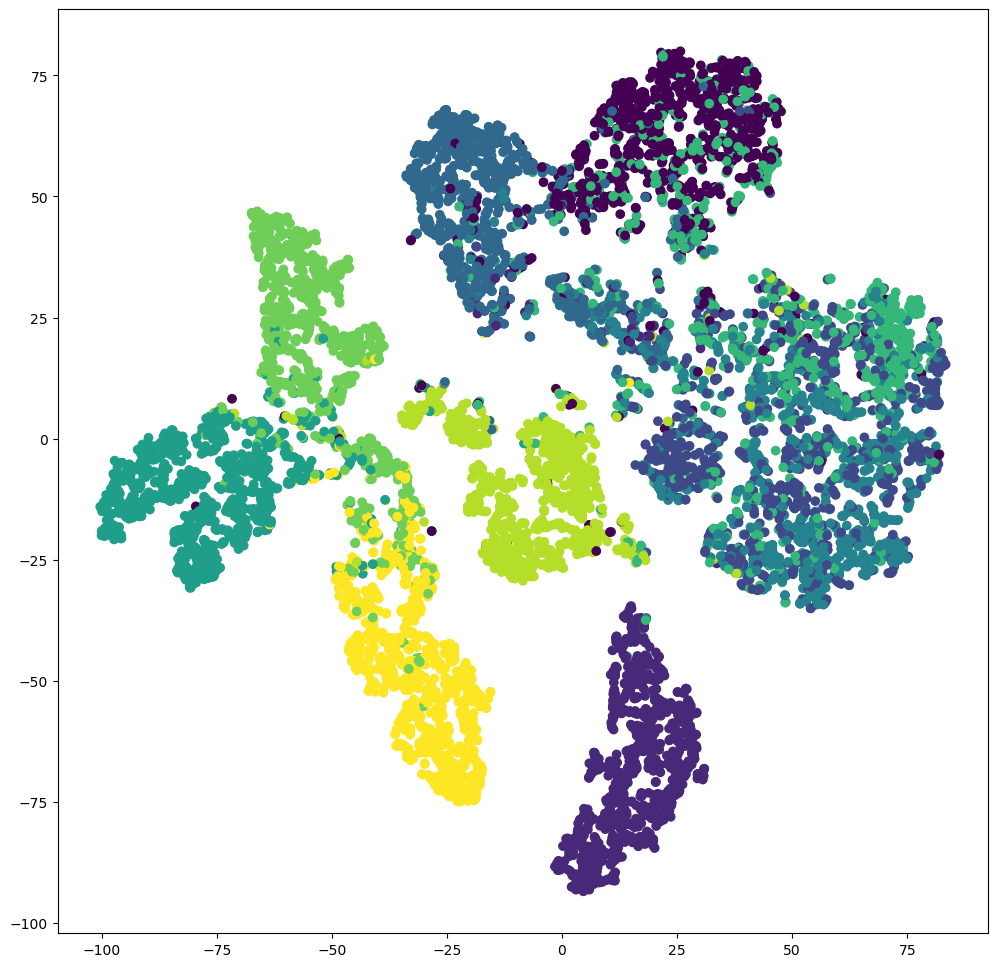

In [6]:
y_test = tf.concat([y for x, y in ds_test], axis=0)
embeddings = base_network.predict(ds_test, verbose=False)
tsne_embeddings = TSNE(random_state=4).fit_transform(embeddings)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = y_test);

### Hard Triplets

Because we can, we'll now rinse and repeat with the hard triplets.

In [9]:
embedding_size = 32
dummy_input = keras.Input((28, 28, 1))
base_network = vgg_net(dummy_input, [8, 16, 32], [256], 0.2, 0)
embedding_layer = layers.Dense(embedding_size, activation=None)(base_network)
embedding_layer = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(embedding_layer)
base_network = keras.Model(dummy_input, embedding_layer)

base_network.compile(optimizer=keras.optimizers.Adam(), loss=triplet_hard_loss, jit_compile=False)
history = base_network.fit(ds_train, epochs=10, validation_data = ds_val)

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/step - loss: 1.1400 - val_loss: 1.0176
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 1.0093 - val_loss: 1.0145
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 1.0048 - val_loss: 1.0086
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 1.0033 - val_loss: 1.0037
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 1.0025 - val_loss: 1.0029
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 1.0021 - val_loss: 1.0028
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 1.0018 - val_loss: 1.0043
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 25ms/step - loss: 1.0016 - val_loss: 1.0025
Epoch 9/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 1.0014 - val_loss: 1.0030
Epoch 10/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - loss: 1.0014 - val_loss: 1.0028


Here, we see larger loss values than we had above. This is not a problem, this is expected. Our network is now looking for the hardest triplets to use in training. All of the triplets that we are using will have a negative pair distance, $d(n,a)$, smaller than the positive pair distance, $d(p,a)$. This means that our loss will always be above 1.

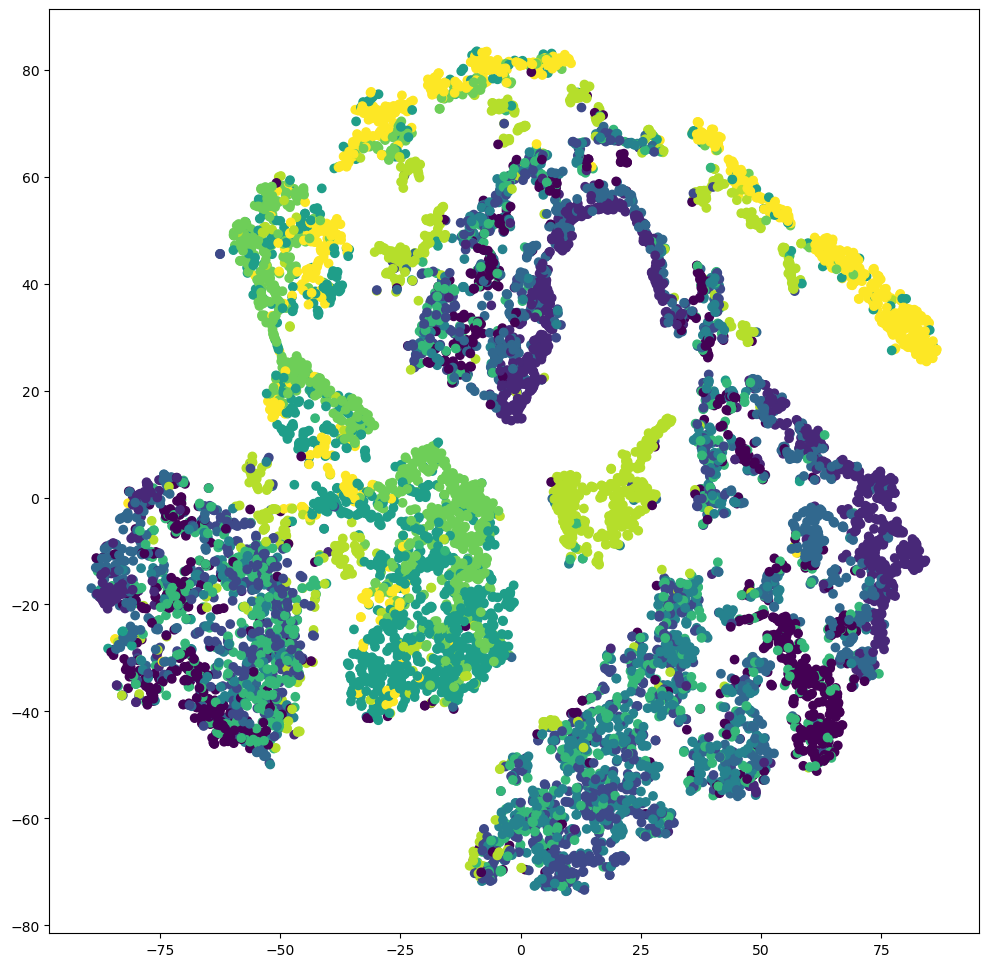

In [10]:
embeddings = base_network.predict(ds_test, verbose=False)
tsne_embeddings = TSNE(random_state=4).fit_transform(embeddings)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = y_test);

Again, we see this working pretty well.

## Final Thoughts

Neither of the above changes to our loss have made things perfect, though that wasn't the aim here. Also, if we really want perfection we need a bigger network and longer training time.

What you hopefully have seen from the above is that we can actually do the whole metric learning thing really easily by thinking carefully about where we place the triplet generation process. By actually creating the triplets in the loss function, the entire process becomes much simpler (though the loss function get's a bit more interesting). [This blog post](https://omoindrot.github.io/triplet-loss) has an excellent discussion of what a loss function for online triplet mining looks like, and if you're interested it's well worth a look to understand how this is done.

Of course, the actual code is also above here - but I think the blog post, perhaps followed by looking at the code, is easier to understand.